## Investigation of Salary Differences in In-person and Remote Employees

In [2]:
# Dependencies
library(ggplot2)
library(dplyr)
library(tidyverse)
library(repr)
library(tidyr)
library(tidymodels)
library(readxl)
library(infer)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
✔ readr     2.1.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ r

### Introduction


These days, many companies offer remote working conditions as an alternative to working from office. Both conditions of work have their pros and cons, and there have , been debates abut whether remote work is better than traditional work. Owing to the differences in the environment, we expect traditional and remote workers to have difference levels of productivity, which may be reflected in terms of their salaries. Thus, in this project, we would like to investigate whether there is a significant difference in the salaries of in-office workers(remote ratio = 0) and remote workers(remote ratio = 100).

The data for this project was obtained from https://ai-jobs.net/salaries/download. We assume that the data was collected randomly and in an unbiased manner and we only focus on the difference between 100% remote and traditional employees. The variables we are interested in are salaries in USD and remote ratio.

The name of the dataset is Data jobs salaries and it contains the salary information of 8225 professionals, along with factors including:
1. Work year
2. Experience level
3. Employment type
4. Job title
5. Salary in USD
6. Employee Residence
7. Company location
8. Remote ratio

We would like to investigate whether there a difference in salary between professionals working remotely (remote_ratio == 100) and those working in a traditional office setting (remote_ratio == 0)? To answer this question, we would like to use two parameters mean and standard deviation. We ask the following questions:

- Is there a difference in the mean salary (in USD) of remote and in-person (office) employees from the salaries dataset.

- Is there a difference in the in the standard deviation of salary (in USD) of remote and in-person (office) employees.

### Preliminary Results

We first load the dataset into R

In [3]:
# Read dataset from CSV format
salaries = read.csv('https://ai-jobs.net/salaries/download/salaries.csv')
head(salaries)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>
1,2023,SE,FT,Data Engineer,234000,USD,234000,US,0,US,M
2,2023,SE,FT,Data Engineer,146000,USD,146000,US,0,US,M
3,2023,MI,FT,Data Scientist,199700,USD,199700,US,0,US,M
4,2023,MI,FT,Data Scientist,70800,USD,70800,US,0,US,M
5,2023,EN,FT,Research Analyst,179000,USD,179000,US,0,US,M
6,2023,EN,FT,Research Analyst,112000,USD,112000,US,0,US,M


First, we read and tidy the data set. We only select the relevant columns, and filter the currency for USD, so that we can make comparisons in salaries. 

In [4]:

# Clean and tidy dataset
# 1. Filter dataset such that remote_ratio is either 0 or 100
salaries_filtered <- salaries %>%
    filter(remote_ratio == 0 | remote_ratio == 100, !is.na(remote_ratio), !is.na(salary), 
           salary_currency == "USD") |>
    select(remote_ratio, salary_in_usd)

#Change column names
colnames(salaries_filtered) <- c("job_type", "salary_in_USD")
 
salaries_job_type <-  salaries_filtered |>
                       mutate(job_type = case_when(job_type == 100 ~ "Remote",
                              job_type == 0 ~ "In-Person")) |>
                              mutate(job_type = as_factor(job_type))

#find Q1, Q3, and interquartile range for values in column Salary_in_USD
Q1 <- quantile(salaries_job_type$salary_in_USD, .25)
Q3 <- quantile(salaries_job_type$salary_in_USD, .75)
IQR <- IQR(salaries_job_type$salary_in_USD)

#only keep rows in dataframe that have values within 1.5*IQR of Q1 and Q3
salaries_job_type <- subset(salaries_job_type, salaries_job_type$salary_in_USD> (Q1 - 1.5*IQR) 
                      & salaries_job_type$salary_in_USD< (Q3 + 1.5*IQR))

head(salaries_job_type)
                              

,job_type,salary_in_USD
,<fct>,<int>
1,In-Person,234000
2,In-Person,146000
3,In-Person,199700
4,In-Person,70800
5,In-Person,179000
6,In-Person,112000


[Table 1.1]

Let us see the proportion of in person and office employes

In [5]:
salaries_job_type |> group_by(job_type) |>
                     summarise(n = n())

job_type,n
<fct>,<int>
In-Person,5350
Remote,3133


[Table 1.2]

We have a fairly large sample size for both in perspon and remote employees. Now we compute estimates of the parameters identified above  (i.e median salary (USD)) and standard deviation.

In [6]:

# Compute estimates of the parameter you identified across your groups. Present this in a table. If relevant, include these estimates in your plot.
salary_estimates <- salaries_job_type %>%
  group_by(job_type) %>%
  summarize(
    salary_mean = mean(salary_in_USD, na.rm = TRUE),
    salary_sd = sd(salary_in_USD, na.rm = TRUE)
  )

head(salary_estimates)

job_type,salary_mean,salary_sd
<fct>,<dbl>,<dbl>
In-Person,156307.5,55533.38
Remote,149422.8,54101.38


[Table 1.3]

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


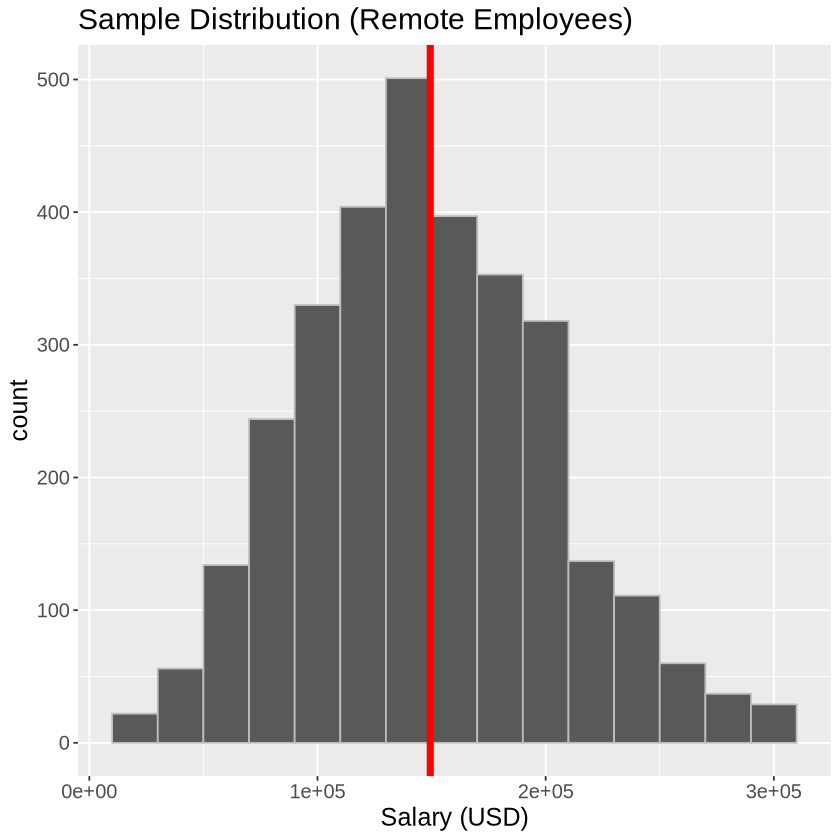

In [7]:
# Plot the relevant raw data, tailoring your plot in a way that addresses your question

salaries_remote <- salaries_job_type |>
                   filter(job_type == "Remote")

salaries_inperson<- salaries_job_type |>
                   filter(job_type == "In-Person")

salaries_boxplot <- ggplot(salaries_job_type, aes(x = as.factor(job_type), y = salary_in_USD)) +
  geom_boxplot(fill = "skyblue", color = "black", alpha = 0.7) +
  labs(title = "Salary Comparison by Type of Job", x = "Type of Work", y = "Salary (in USD)", color = "Mean") + 
  theme(text = element_text(size = 15))

salaries_remote <- ggplot(salaries_remote, aes(x = salary_in_USD)) +
                   geom_histogram(binwidth = 20000, color = "grey") + 
                   xlab("Salary (USD)") +
                   ggtitle("Sample Distribution (Remote Employees)") +
                   theme(text = element_text(size = 15))+
                   geom_vline(xintercept = salary_estimates$salary_mean[2], size = 2, color = "red")
                              
salaries_inperson<- ggplot(salaries_inperson, aes(x = salary_in_USD)) +
                    geom_histogram(binwidth = 20000, color = "grey") + 
                    xlab("Salary (USD)") +
                    ggtitle("Sample Distribution (In Person Employees)") +
                    theme(text = element_text(size = 15))+
                    geom_vline(xintercept = salary_estimates$salary_mean[1], size = 2, color = "red")

salaries_remote

[Fig 1.1]

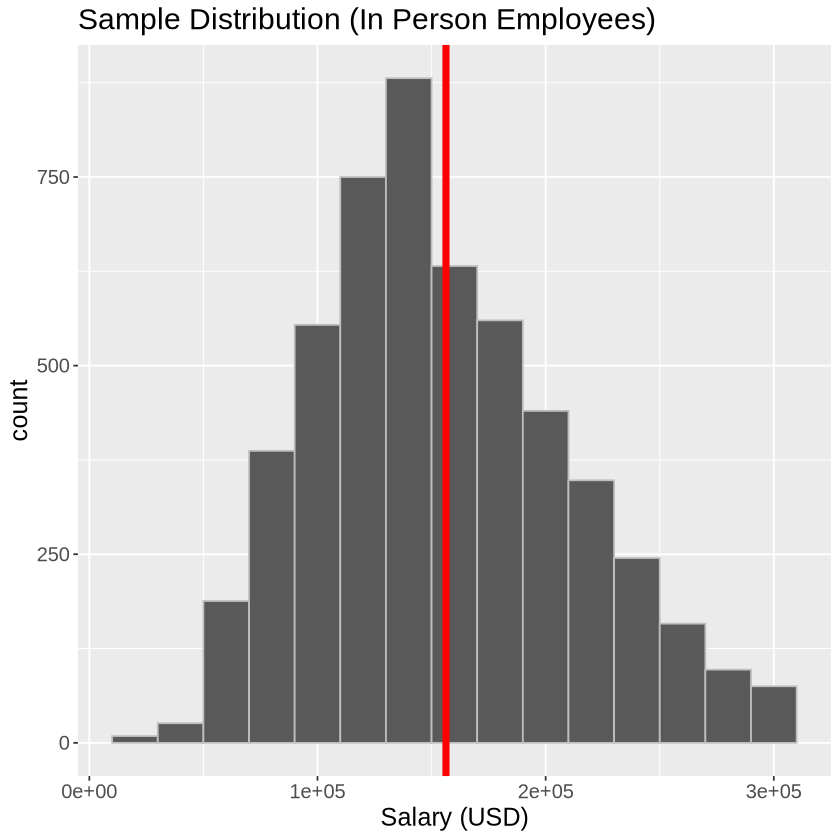

In [8]:
salaries_inperson

[Fig 1.2]

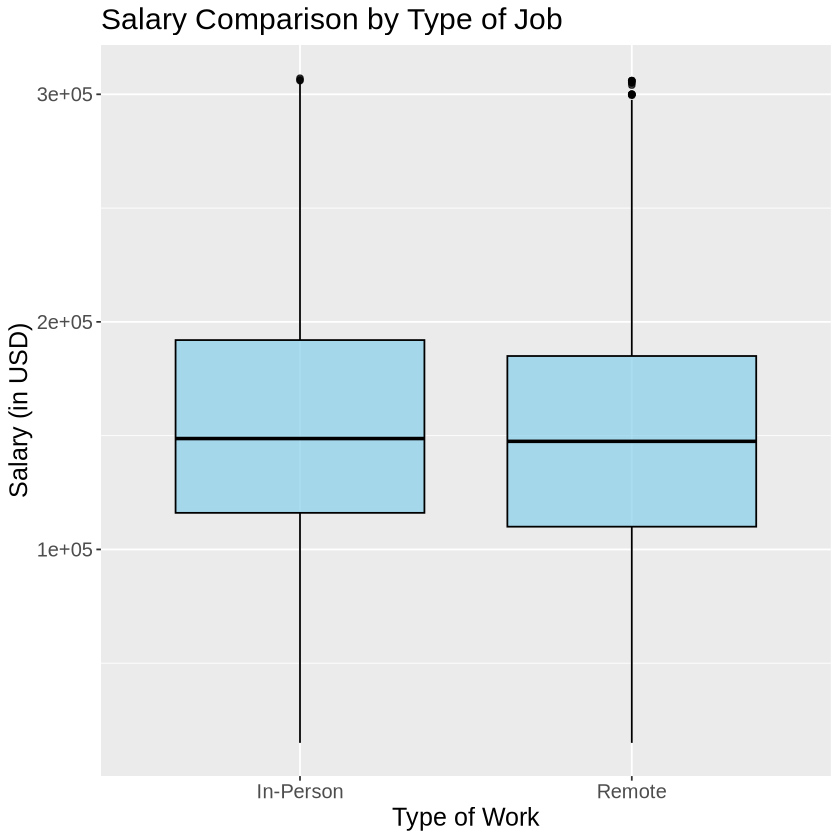

In [9]:
salaries_boxplot

[Fig 1.3]

### Methods

The estimates themselves are not enough to answer our question because the difference in mean salaries and standard deviation of salaries could be purely due to sampling variations. Additionally, the boxplot visually represents the distribution of salaries across employees working remotely and in-office, but lacks the statistical evidence to draw any meaningful conclusions. 

We try to address this by conducting a thorough investigation using hypothesis tests and confidence intervals. 

Hypothesis test for difference of means


$\mu_1$ = The mean salary for 100% remote employees <br>
$\mu_2$ = The mean salary for in-office employees 



We will test

$H_0$: There is no difference in the mean salary of 100% remote and in-office employees

$H_1$ : There is a difference in the mean salary of 100% remote and in-office employees

$$ H_0:  \mu_1 - \mu_2 = 0$$
$$H_1:  \mu_1 - \mu_2 \ne 0$$



Hypothesis test for difference of sd

$H_0$: There is no difference in the sd of salary of 100% remote and in-office employees

$H_1$ : There is a difference in the sd of salary of 100% remote and in-office employees

It would also be interesting to compare the standard deviation of the salaries of the two groups. 

$$ H_0:  \sigma_1 - \sigma_2 = 0$$
$$H_1:  \sigma_1 - \sigma_2 \ne 0$$



*Confidence Intervals*: We also plan to create bootstrap distribution of difference of means by sampling with replacement from our sample. Then we will create 95% confidence intervals to visualise the results and compare them to the hypothesis test. We will do the same for our scale parameter (i.e standard deviation)

We expect to find a definitive conclusion as to whether there is a significant difference in salaries of employees who work remotely when compared to the salaries of employees who work in person.


Nowadays, remote jobs have been on the rise ever since the covid-19 pandemic occurred. Transitioning to remote work would offer both numerous benefits for companies such as an increase in productivity in employees as it promotes flexibility which enables employees to work in an environment that suits their individual needs and preferences.(Yuliati et al., 2023)

The findings from our project can reveal disparities in the workspace and guide businesses to address these disparities and it could equip employees  with necessary information while negotiating hybrid or remote work arrangements. 


### Results

#### Testing the Difference of Means Using  a Theory Based Approach

We will test the hypothesis: 

$$ H_0:  \mu_{\text{remote}}- \mu_{\text{in-person}}= 0$$
$$H_1:  \mu_{\text{remote}}- \mu_{\text{in-person}} \ne 0$$

Using the test statistic 

$$
T = \frac{\bar{x}_{\text{remote}} - \bar{x}_{\text{in-person}}}{\sqrt{\frac{s^2_{\text{remote}}}{n_1}+\frac{s^2_{\text{in-person}}}{n_2}}}
$$

The sample distributions of remote and in person employees calculated above are slightly asymmetric but the sample size seems large enough for the conditions of the Central Limit Theorem to be valid. Hence the  the test statistic should follow a t distribution with degreees of freedom:

$$
\nu = \frac{
    \left(\frac{s_{remote}^2}{n_1}+\frac{s_{in-person}^2}{n_2}\right)^2
}
{
\frac{s_{remote}^4}{n_1^2(n_1-1)}+\frac{s_{in-person}^2}{n_2^2(n_2-1)}
}
$$




Let us calculate the test statistic and the p value 

In [10]:
summary <- salaries_job_type |>
           group_by(job_type) |>
           summarize(mean = mean(salary_in_USD),
                     var = var(salary_in_USD),
                     n = n())
summary


job_type,mean,var,n
<fct>,<dbl>,<dbl>,<int>
In-Person,156307.5,3083956095,5350
Remote,149422.8,2926959475,3133


[Table 2.1.1]

In [11]:
#Calculate degrees of freedom
numerator_df <- (summary$var[1]/summary$n[1] + summary$var[2]/summary$n[2])^2
denomator_df <- (summary$var[1]^2/(summary$n[1]^2 * (summary$n[1] - 1)) + 
                 summary$var[2]^2/(summary$n[2]^2 * (summary$n[2] - 1)))

df <- round(numerator_df/denomator_df, 0)

#Calculate test statistic
t_value <- (summary$mean[2] - summary$mean[1])/sqrt(summary$var[1]/summary$n[1] + summary$var[2]/summary$n[2])


#Calculate p-value 
p_value1 <- 2 * pt(t_value, df = df)

result <- paste("The p-value at 0.05 significance level is ", p_value1)
print(result)

[1] "The p-value at 0.05 significance level is  2.21070561838508e-08"


Let us use R's t.test function to do the same t.test. 

In [12]:
using_t_test_function <- tidy(
        t.test(x = select(filter(salaries_job_type, job_type == "Remote"), salary_in_USD),
               y = select(filter(salaries_job_type, job_type == "In-Person"), salary_in_USD),
               alternative = "two.sided"))

using_t_test_function

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
-6884.656,149422.8,156307.5,-5.6014,2.210711e-08,6696.599,-9294.074,-4475.238,Welch Two Sample t-test,two.sided


[Table 2.1.2]

In [13]:
salaries_remote <- salaries_job_type |>
                   filter(job_type == "Remote") |>
                   pull(salary_in_USD) 

salaries_inperson<- salaries_job_type |>
                   filter(job_type == "In-Person") |>
                   pull(salary_in_USD) 



We also calulcate the 95% confidence interval for the our parameter to compare our results to the t test. 

In [14]:
salaries_diff_means_ci <- 
    tibble(
        lower_ci = mean(salaries_remote) - mean(salaries_inperson) + qt(0.025, df) * sqrt(var(salaries_remote)/length(salaries_remote) + var(salaries_inperson)/length(salaries_inperson)),
        upper_ci = mean(salaries_remote) - mean(salaries_inperson) + qt(0.975, df) * sqrt(var(salaries_remote)/length(salaries_remote) + var(salaries_inperson)/length(salaries_inperson)))

salaries_diff_means_ci

lower_ci,upper_ci
<dbl>,<dbl>
-9294.074,-4475.238


[Table 2.1.3]

As seen from the results above, our results using a theory based approach match up with the results obtained from the t.test function in R

#### Testing the Difference in Means by Bootstrapping

We conducted the same hypothesis test as the one done above using a simulation based approach. To minimise computational power used, we take a subset of our dataset of size 1000

In [15]:
set.seed(123)
#Taking a smaller sample for bootstrapping 
salaries_small <- rep_sample_n(salaries_job_type, size = 1000, replace = FALSE)

summary_small <- salaries_small |>
                   group_by(job_type) |>
                   summarise(mean = mean(salary_in_USD))
                
summary_small
obs_mean_diff_salaries <- (summary_small$mean[2] - summary_small$mean[1])

null_model_salaries <-
    salaries_small |>
    specify(formula = salary_in_USD ~ job_type)  |>
    hypothesize(null = "independence") |>
    generate(reps = 1000, type = "permute") |>
    calculate(stat = "diff in means", c("Remote", "In-Person")) |>
    get_p_value(obs_stat = obs_mean_diff_salaries, direction = "both")

head(null_model_salaries)

job_type,mean
<fct>,<dbl>
In-Person,154399.8
Remote,149406.6


p_value
<dbl>
0.15


Using the principles of bootstrapping, we calculate the simulated confidence intervals for the difference of the mean salaries.

[Table 2.2.1]

In [16]:
# Calculate the confidence interval
set.seed(1)
bootstrap_ci <-
    salaries_small |>
    specify(formula = salary_in_USD ~ job_type) |>
    generate(reps = 1000, type = "bootstrap") |>
    calculate(stat = "diff in means", c("Remote", "In-Person")) |>
    get_ci(level = 0.95, type = "percentile")

bootstrap_ci

lower_ci,upper_ci
<dbl>,<dbl>
-11636.57,1586.798


[Table 2.2.2]

#### Testing Difference in Standard Deviation by Bootstrapping

Similar to the hypothesis test conducted for the difference in the means, we take a small sample from our dataset of size 600 and bootstrap it to see if there is a significant difference in the standard deviations of remote and office workers

We use the results from the bootstrap to test our hypothesis:
$$ H_0:  \sigma_1 - \sigma_2 = 0$$
$$H_1:  \sigma_1 - \sigma_2 \ne 0$$


In [17]:
# Take a smaller sample from salaries_job_type

n_sample = 1000
salaries_sample <-
    salaries_job_type %>%
    sample_n(size=n_sample, replace=FALSE)

In [18]:
#Get the observed difference in standard deviation between In-Person and Remote
obs_diff_in_sd <- 
    salaries_sample %>% 
    group_by(job_type) %>% 
    summarise(sd = sd(salary_in_USD)) %>%
    pivot_wider(names_from = job_type, values_from = sd) %>%
    transmute(diff = `Remote` - `In-Person`) %>%
    pull(diff)

obs_diff_in_sd

[1] 2045.502

Using the principles of bootstrap sampling, we created a null model and plotted our observed test statistic on the null model for a better visualization of our statistic

In [19]:
# Specify number of bootstrap samples
n_bootstrap = 1000
n = nrow(salaries_sample)

# Create null model via bootstrap sampling
null_model <-
  salaries_sample %>%
  rep_sample_n(size=n, reps=n_bootstrap, replace=TRUE) %>%
  group_by(replicate, job_type) %>%
  summarise(sd_salary = sd(salary_in_USD)) %>%
  group_by(replicate) %>%
  summarise(diff_in_sd = diff(sd_salary)) %>%
  mutate(diff_in_sd = diff_in_sd + (0 - obs_diff_in_sd))

head(null_model)

`summarise()` has grouped output by 'replicate'. You can override using the
`.groups` argument.


replicate,diff_in_sd
<int>,<dbl>
1,164.7187
2,-2409.7062
3,3201.1578
4,6737.4150
5,169.3598
6,-1220.2393


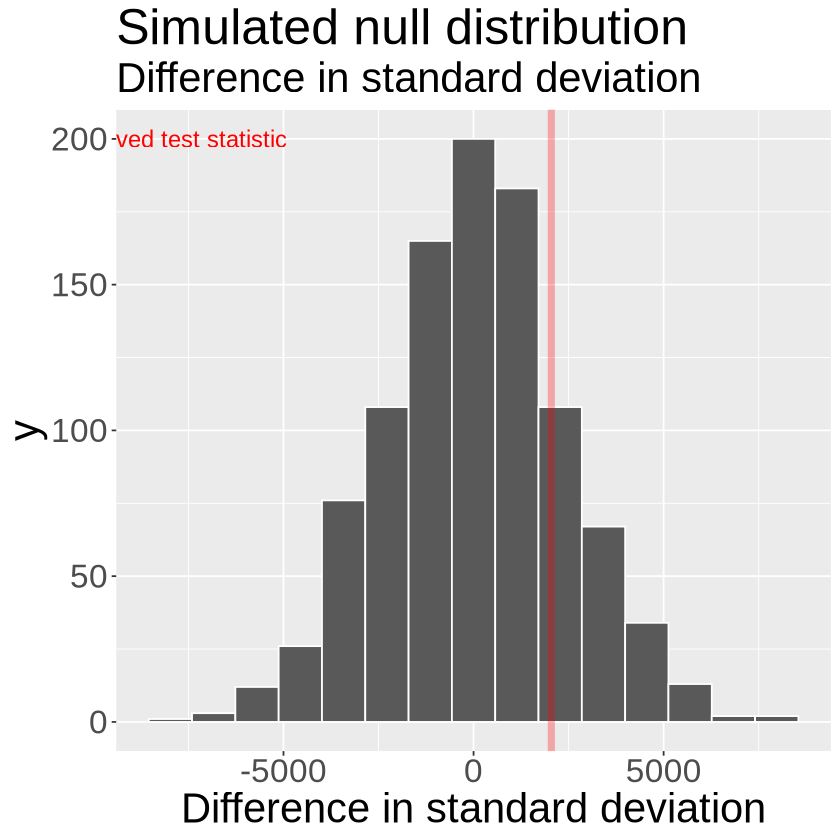

In [20]:
# Plot the null model and 
null_model_plot <-
     null_model %>% 
     ggplot() +
     geom_histogram(aes(x=diff_in_sd), bins = 15, color="white") +
     geom_vline(xintercept = obs_diff_in_sd, color = "red", alpha=.3, lwd=2) + 
     xlab("Difference in standard deviation") + 
     theme(text = element_text(size=25)) + 
     ggtitle("Simulated null distribution", subtitle = "Difference in standard deviation")  +
     annotate("text", x = -8000, y = 200, label = "Observed test statistic", color="red", size= 5)

null_model_plot

[Fig 3.1]

We then used the null model to calculate the p-value for our observed test statistic. 

In [21]:
# Compute P-value from null model
p_value <- mean(null_model$diff_in_sd < -abs(obs_diff_in_sd) |
                null_model$diff_in_sd > abs(obs_diff_in_sd))

p_value

[1] 0.374

### Discussion

This project aims to find if there is a significant difference in the salaries of in-office workers and remote workers for various companies, and we carried out some hypothesis tests

$$ H_0:  \mu_{\text{remote}}- \mu_{\text{in-person}}= 0$$
$$H_1:  \mu_{\text{remote}}- \mu_{\text{in-person}} \ne 0$$

Where $\mu_{\text{remote}}$ is the mean salary for a remote worker and $\mu_{\text{in-person}}$ is the mean salary of an office worker
When testing the difference in the mean salaries on office workers and remote workers, the two-sided t-test gave the p-value of:

In [22]:
p_value1

[1] 2.210706e-08

Which suggests that the observed difference in the mean salaries would be very unlikely under the null hypothesis unless we were very unlucky.

This idea is also reinforced when looking into the 95% confidence intervals for the mean difference:

In [23]:
salaries_diff_means_ci

lower_ci,upper_ci
<dbl>,<dbl>
-9294.074,-4475.238


Since the p-value of our test statistic is much less that our significance level of 0.05 and the confidence interval of the test statistic does not inclue 0, we can say that it is safe to reject the null hypothesis and conclude that there is a statistically significant difference in the mean salaries of the in-office and remote workers

We also simulated the distribution of our test statistic by bootstrapping, with a size of 1000 to minimize computational power, and the p-value obtained from it was 0.026, which still gets rejected under the significance level of 0.05 but the difference in the p-values of bootstrapping and theoretical approach seems to be the result of the smaller sample size for the bootstrapped sample. While both the bootstrapping and theory based approach seem to be reliable, in our case, we should be more confident in the results of the theory based approach because it was applied to a larger sample that met the conditions of the CLT. 

The confidence interval of the difference in mean salaries obtained from the bootstrapped sample is:

In [24]:
bootstrap_ci

lower_ci,upper_ci
<dbl>,<dbl>
-11636.57,1586.798


Which when compared to the CI obtained through the theoretical approach, seemes to be wider, but this can be explained with the smaller sample size of the bootstrapped sample as well. This CI still does not contain 0, so our inference of having a statistically significant mean difference still holds.

The same cannot be said for the standard deviation of the means as the hypothesis testing on the standard deviation returned the p-value of:

In [25]:
p_value

[1] 0.374

Which means that under the significance level of 0.05, we cannot confidently say that there is a significant difference in the standard deviations of the salaries of remote and office workers. For this hypothesis, we could not use a theory based approach because there was no formula available to approximate the sampling distribution of the test statistic. 

#### Limitations

Some limitations of our project that should be kept in mind are:
1. We did not factor in some confounding variables such as the size of the company, position of the employee etc. which can introduce some bias in the salaries of the employees.
3. This dataset does not include all of the job opportunities in the data/ai sectors, which means that there is a possibility of having a sampling bias in this dataset.
4. When looking at Fig 1.3, we can see that there are some outliers in our dataset, which can deviate the results of the mean difference of the salaries

#### Implications 

1. We can safely conclude that there is a significant difference in the mean salaries of office and remote workers, and employes should try to bridge this gap to avoid employee dissatisfaction
2. Employees should understand the impacts that their work arrangement choices can have on them financially to make a better and more informed choice
3. While we haven’t shown that office workers get paid more than remote workers, our confidence intervals shows that office workers might be paid more, which can be looked into a bit further in another study.


#### Future questions: <br>
1. Given a general increase in productivity levels, should companies offer more remote jobs to their employees? <br>
2. Are there specific jobs that have more benefits when working in a remote setup? <br>
3. How does the adaptation of remote work affect physical work spaces in the long term? <br>
4. How does the job satisfaction of remote workers compare to traditional office workers? How does this vary across different industries? 

### References

Yuliati, L., Smith, P. A. W., &amp; Prasetyaningtyas, S. W. (2023). The influence of flexible working hours, work from home, work stress, and salary on employee performance at PT Armada auto tara during COVID-19 pandemic. Quantitative Economics and Management Studies, 4(3), 402–413. https://doi.org/10.35877/454ri.qems1619 

Barrero, J. M. (2022). WFH research updates: December 2022. Marketing, Automation &amp; Email Platform. https://mailchi.mp/d00d2c93d7bc/wfh-research-updates-december-2022 